In [1]:
from __future__ import print_function, division
import os
from pathlib import Path

import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

ROOT_DIR = '../data/'
CLASSES = {
    0: 'safe driving',
    1: 'texting - right',
    2: 'talking on the phone - right',
    3: 'texting - left',
    4: 'talking on the phone - left',
    5: 'operating the radio',
    6: 'drinking',
    7: 'reaching behind',
    8: 'hair and makeup',
    9: 'talking to passenger'
}

DRIVERS = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
           'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
           'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
           'p075', 'p081'
          ]

In [2]:
class StateFarmDataset(torch.utils.data.Dataset):
    """Distracted Driver Detection dataset."""

    def __init__(self, drivers: pd.DataFrame, root_dir: str = '../data/', transform=None):
        """
        Args:
            drivers: List of drivers to consider in this dataset
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        df = pd.read_csv(os.path.join(root_dir, 'driver_imgs_list.csv'))
        # filter on the drivers
        df = df[df.subject.isin(drivers)]
        # filepath is in the format '../data/imgs/train/c7/img_62010.jpg'
        df["filepath"] = root_dir + 'imgs/train/' + df["classname"] + '/'+ df["img"]
        # classname have the format cX where X is the id of the class
        df["class"] = df.classname.str[-1]
        
        self.files = df[['filepath', 'class']].sample(frac=1).reset_index(drop=True)
        self.transform = transform


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.files.iloc[idx, 0]
        image = io.imread(img_name)
        class_label = int(self.files.iloc[idx, 1:])

        if self.transform:
            image = self.transform(image)

        return image, class_label

In [3]:
from sklearn.model_selection import train_test_split

# split training and testing data using drivers
train_drivers, test_drivers = train_test_split(DRIVERS, test_size=0.3)
train_drivers, val_drivers = train_test_split(train_drivers, test_size=0.3)

In [4]:
driver_dataset = StateFarmDataset(
    drivers=train_drivers,
    root_dir=ROOT_DIR, 
    transform=transforms.Compose([transforms.ToPILImage(), transforms.Resize(224),transforms.ToTensor()])
)

dataloader = DataLoader(driver_dataset, batch_size=4,shuffle=True, num_workers=4)

In [5]:
from tqdm import tqdm

# Compute the mean and std for the dataset to use for normalization
mean = 0.
std = 0.
nb_samples = 0.
for data, label in tqdm(dataloader):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

100%|██████████| 2622/2622 [00:27<00:00, 93.74it/s]


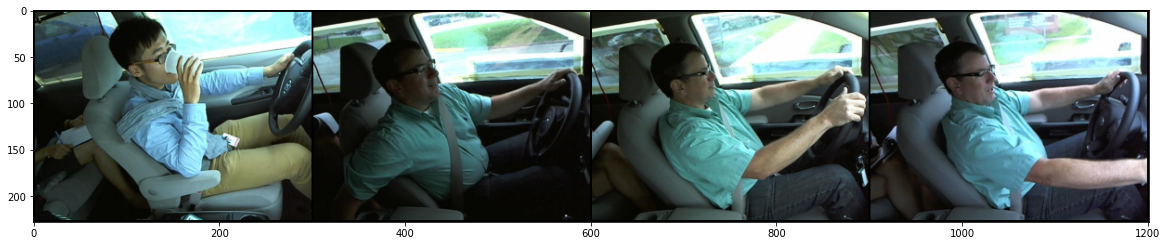

drinking
reaching behind
safe driving
operating the radio


In [164]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(dataloader)
images, labels = dataiter.next()
plt.figure(figsize=(20,6))
# show images
imshow(utils.make_grid(images))
# print labels
print('\n'.join(CLASSES[int(labels[j])] for j in range(4)))

In [7]:
from torchvision.models import vgg19_bn, VGG

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
            
model = vgg19_bn(pretrained=True, progress=False)
set_parameter_requires_grad(model, True)
model.classifier[6] = torch.nn.Linear(4096, 10)

In [11]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [98]:
import torch.optim as optim
from torch import nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [99]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        break
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(validationloader, 0):
            inputs, labels = data
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        print('[%d, %5d] val loss: %.3f' % (epoch + 1, i + 1, val_loss / 2000))
       
print('Finished Training')

Finished Training
